In [86]:
"""
Make mask for segmentation training from the annotation data of
MoNuSegTrainingData.

"""

import math
import argparse
from lxml import etree
from pathlib import Path
import numpy as np
import cv2
import os
import sys
from types import SimpleNamespace
# add parent directory to path (cytoark)
sys.path.insert(0,os.path.dirname(os.getcwd()))
sys.path.insert(0,os.path.dirname(os.path.dirname(os.getcwd())))
from cisc.imutils import contours2labels, resolve_label_channels 
from skimage.measure import label


def read_annotation(path):
    """
    [Summary]
        Read annotation file into buffer and parse it.

    [Arguments]
        path {pathlib.PosixPath}
        -- path to the annotation file.

    [Returns]:
        annotations {list}
        -- list of annotations with each annotation encoded
           as numpy.ndarray values.
    """
    tree = etree.parse(str(path))
    regions = tree.xpath("/Annotations/Annotation/Regions/Region")
    annotations = []
    for region in regions:
        points = []
        for point in region.xpath("Vertices/Vertex"):
            points.append([math.floor(float(point.attrib["X"])),
                           math.floor(float(point.attrib["Y"]))])
        annotations.append(np.array(points, dtype=np.int32))
    return annotations


def read_img(path):
    """
    [Summary]
        Read an image file corresponding to the annotation file.

    [Arguments]
        path {pathlib.PosixPath}
        -- path to the image file.

    [Returns]
        height {int}
        -- height value of image encoded as numpy.ndarray values.

        width {int}
        -- height value of image encoded as numpy.ndarray values.
    """
    img = cv2.imread(str(path), 1)
    height, width = img.shape[0:2]
    return height, width, img


def to_mask(annotations, height, width):
    """
    [Summary]
        Make the mask image from the annotation and image sizes.

    [Arguments]
        # Described as above.

    Returns:
        mask {numpy.ndarray}
        -- mask image with each pixels {0, 1}.
    """
    mask = np.zeros([height, width], dtype=np.uint8)
    for annotation in annotations:
        mask = cv2.drawContours(mask, [annotation], 0, True, thickness=cv2.FILLED)
    return mask


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("dir_path")
    # TODO::convert to asap
    parser.add_argument("-c", "--convert_to_asap")
    args = parser.parse_args()
    return args


# def main():
#     # args = get_args()
#     args = SimpleNamespace()
#     args.dir_path='E:\MoNuSegTestData\MoNuSegTestData'
#     dir_path = Path(args.dir_path)
#     out_path = dir_path/"masks"
#     out_path.mkdir(exist_ok=True)

#     imgs = dir_path.glob("*.tif")

#     for path in imgs:
#         height, width = read_img(path)
#         anno_path = str(dir_path/path.stem) + ".xml"
#         annotations = read_annotation(anno_path)
#         mask = contours2labels(annotations, [height, width])
        #   resolve_mask = resolve_label_channels(mask)
#         cv2.imwrite(f"{str(out_path)}/{path.stem}.png",
#                     mask, (cv2.IMWRITE_PXM_BINARY, 1))

# if __name__ == '__main__':
#     main()

# args = get_args()
args = SimpleNamespace()
args.dir_path='E:\MoNuSegTestData\MoNuSegTestData'
dir_path = Path(args.dir_path)
out_path = dir_path
out_path.mkdir(exist_ok=True)

imgs = dir_path.glob("*.tif")
square_size = 256

for path in imgs:
    height, width, img = read_img(path)
    img = cv2.resize(img, (1024, 1024), interpolation=cv2.INTER_LINEAR)
    cv2.imwrite(str(dir_path/path.stem) + ".png", img)
    anno_path = str(dir_path/path.stem) + ".xml"
    annotations = read_annotation(anno_path)
    # resolve_mask = label(to_mask(annotations, height, width))
    mask = contours2labels(annotations, [height, width])
    resolve_mask = label(resolve_label_channels(mask))
    resolve_mask = cv2.resize(resolve_mask, (1024, 1024), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(f"{str(out_path)}/{path.stem}.tiff",resolve_mask)

    # count = 0
    # for i in range(4):
    #     for j in range(4):
    #         # Define the coordinates of the square
    #         y1 = i * square_size
    #         y2 = y1 + square_size
    #         x1 = j * square_size
    #         x2 = x1 + square_size
            
    #         # Extract the square
    #         square = img[y1:y2, x1:x2]
    #         square_lbl = resolve_mask[y1:y2, x1:x2]
            
    #         # Save the square
    #         square_filename = os.path.join(str(dir_path), f'{path.stem}_{count}.png')
    #         cv2.imwrite(square_filename, square)
    #         square_filename = os.path.join(str(out_path), f'{path.stem}_{count}.tiff')
    #         cv2.imwrite(square_filename,resolve_mask)
    #         count += 1


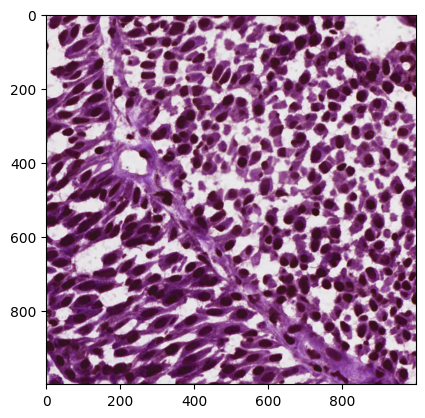

In [76]:
plt.imshow(img)

cv2.imwrite(str(dir_path/path.stem) + ".png", img)

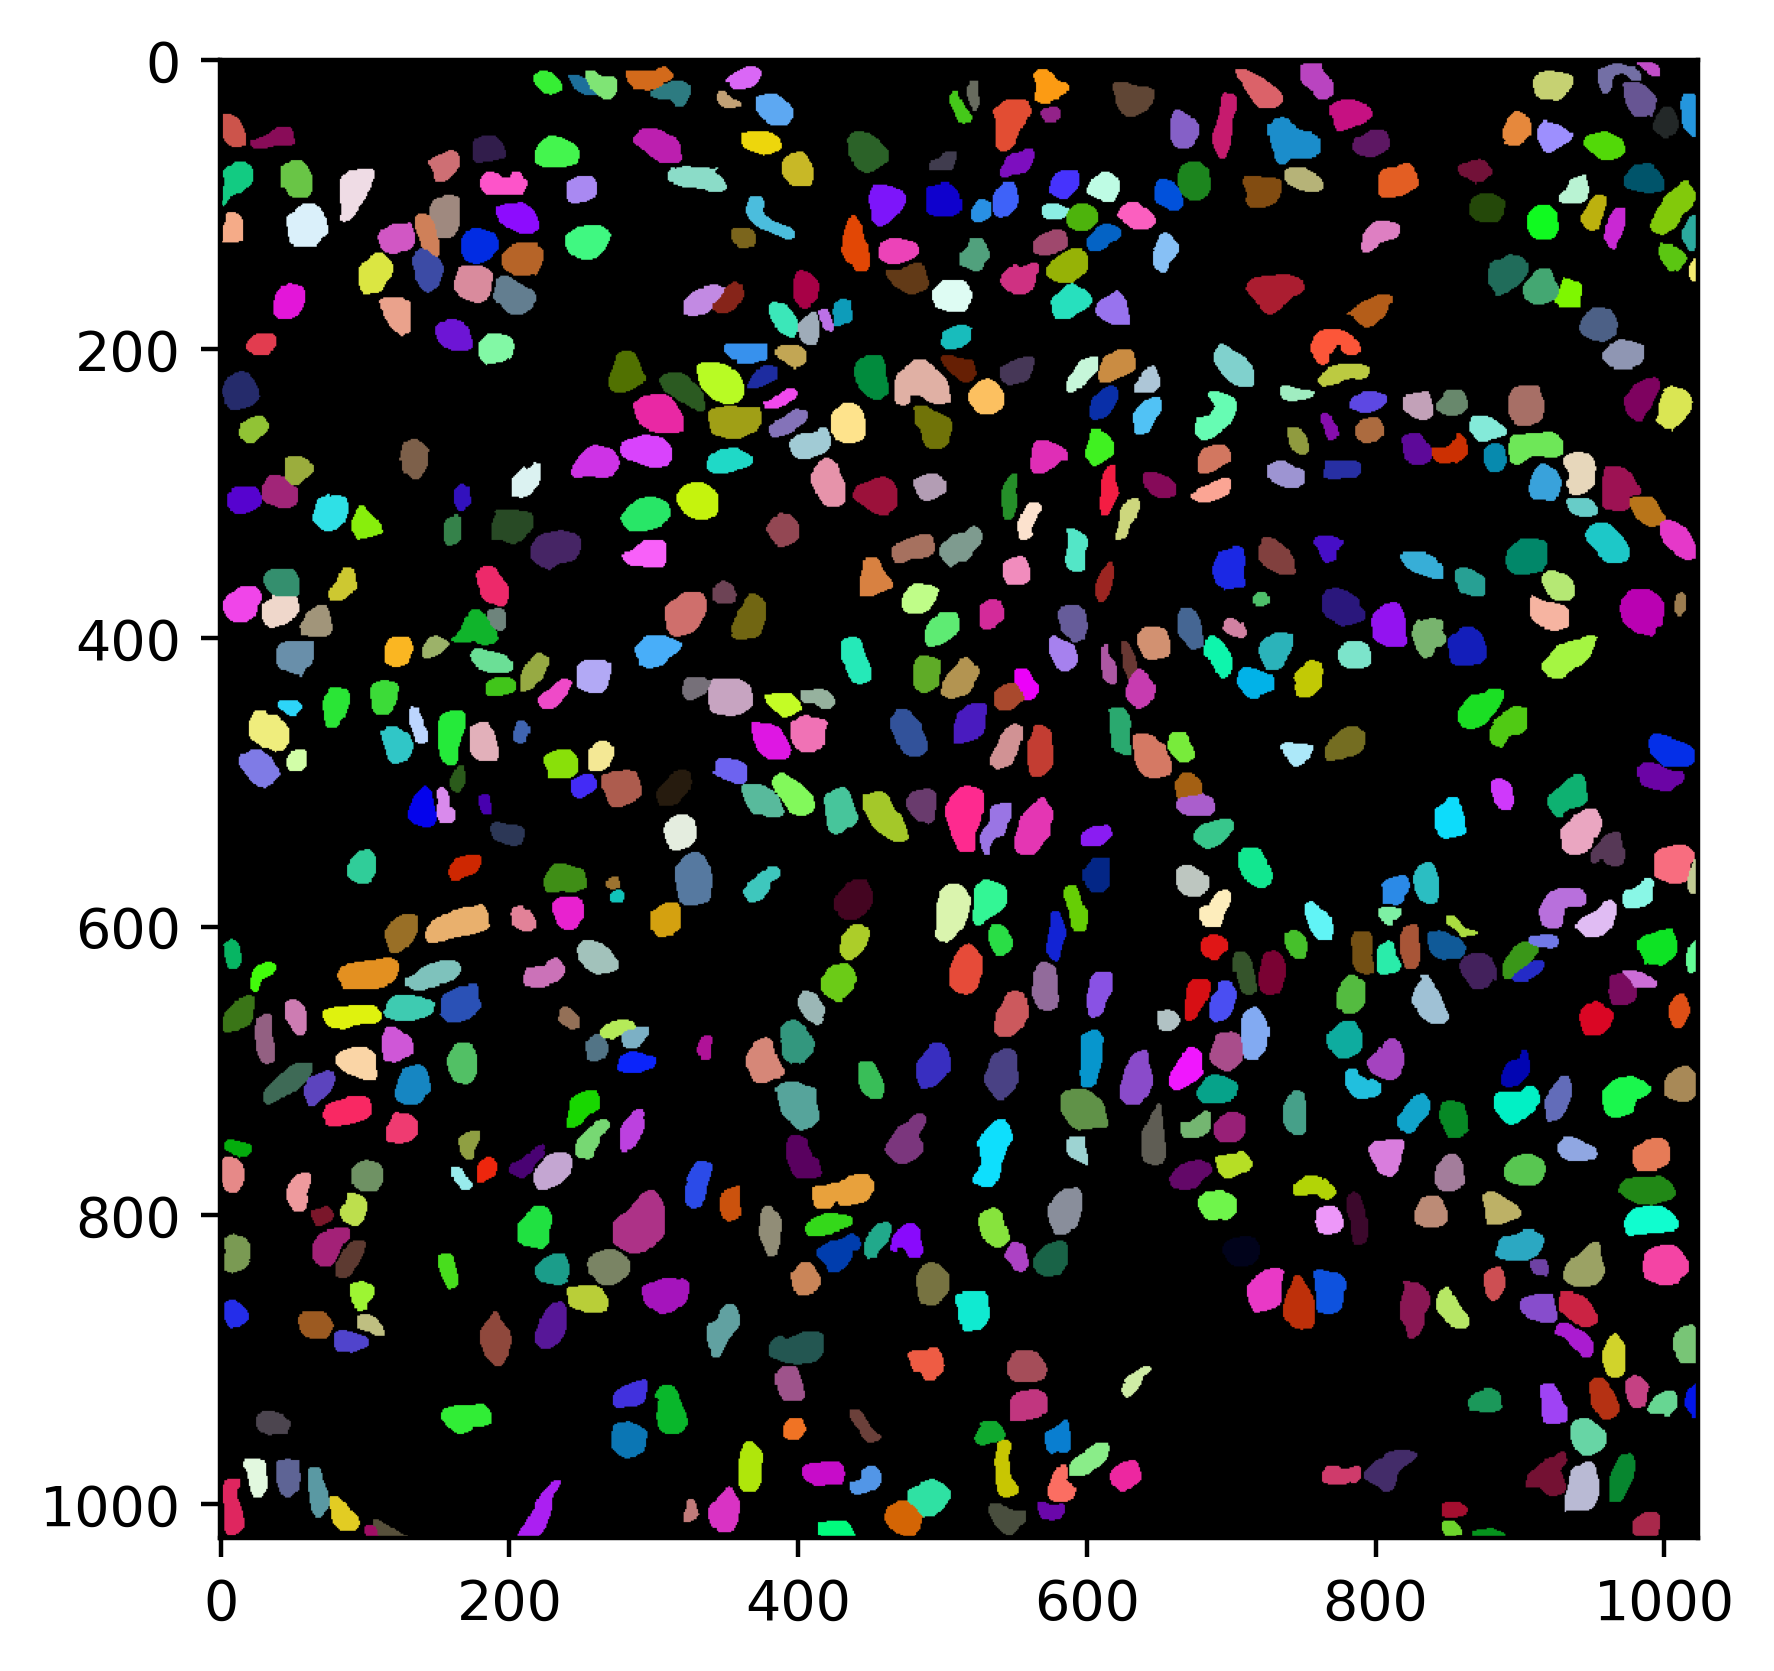

In [79]:
# labelmap = cv2.cvtColor(cv2.imread(os.path.join('E:\MoNuSegTestData\MoNuSegTestData\masks', '{0}.png'.format('TCGA-2Z-A9J9-01A-01-TS1')), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
labelmap = cv2.imread(os.path.join('E:\MoNuSegTestData\MoNuSegTestData\masks', '{0}.tiff'.format('TCGA-2Z-A9J9-01A-01-TS1')), -1)
plt.figure(dpi=400)
RGB_data = np.zeros(labelmap.shape, dtype='float32')
nlabel = len(np.unique(label(labelmap)))
rgb_image = label2rgb(
label(labelmap), colors=np.random.random((nlabel, 3)),saturation=0,alpha=0.7)#, bg_label=0
plt.imshow(rgb_image)